In this notebook, I 
- visualize the dataset. 
- some basic image enhancement techniques using skiimage.
- Many images have multiple annotations. I show how to select according to value counts and visualize it 


You may find the following links useful
- [EDA](https://www.kaggle.com/peterchang77/exploratory-data-analysis)

I will keep updating the kernel as i explore further.

# Loading required libraries

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.transform import resize
from skimage.morphology import label
from skimage.feature import hog
from skimage import exposure
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.feature import canny
from skimage.filters import sobel
from skimage.morphology import watershed
from scipy import ndimage as ndi
import warnings
warnings.filterwarnings("ignore")
from skimage.segmentation import mark_boundaries
from scipy import signal
import cv2
import glob, pylab, pandas as pd
import pydicom, numpy as np
import tqdm
import gc
gc.enable()
import glob

from skimage.transform import resize
from skimage.morphology import label
from skimage.feature import hog
from skimage import exposure
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.feature import canny
from skimage.filters import sobel
from skimage.morphology import watershed
from scipy import ndimage as ndi
import warnings
warnings.filterwarnings("ignore")
from skimage.segmentation import mark_boundaries

import sys
sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation/')
from mask_functions import rle2mask

Using TensorFlow backend.


In [2]:
os.listdir('../input')

['siim-acr-pneumothorax-segmentation-data',
 'siim-acr-pneumothorax-segmentation']

In [3]:
sample_files = glob.glob('../input/siim-acr-pneumothorax-segmentation/sample images/*.dcm')
len(sample_files)

10

# Some utility functions

In [4]:
df = pd.read_csv('../input/siim-acr-pneumothorax-segmentation/sample images/train-rle-sample.csv',header=None)
df.head()

,0,1
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1


In [5]:
import cv2
from IPython.display import display, Image
def cvshow(image, format='.png', rate=255 ):
    decoded_bytes = cv2.imencode(format, image*rate)[1].tobytes()
    display(Image(data=decoded_bytes))
    return

# Visualizing Sample Images

In [6]:
j = 0
nImg = 10
img_ar = np.empty(0)
while img_ar.shape[0]!=nImg:
#     dcm_file = '../input/../input/sample images/%s.dcm' % patientId
    dcm_file = sample_files[j]
    dcm_data = pydicom.read_file(dcm_file)
    img = np.expand_dims(dcm_data.pixel_array,axis=0)    
    if j==0:
        img_ar = img
    elif (j%100==0):
        print(j,'images loaded')
    else:
        img_ar = np.concatenate([img_ar,img],axis=0)
    j += 1
    

In [7]:
def imgtile(imgs,tile_w):
    assert imgs.shape[0]%tile_w==0,"'imgs' cannot divide by 'th'."
    r=imgs.reshape((-1,tile_w)+imgs.shape[1:])
    return np.hstack(np.hstack(r))

#usage
tiled = imgtile(img_ar,5)
# cvshow(tiled)
tiled.shape

(2048, 5120)

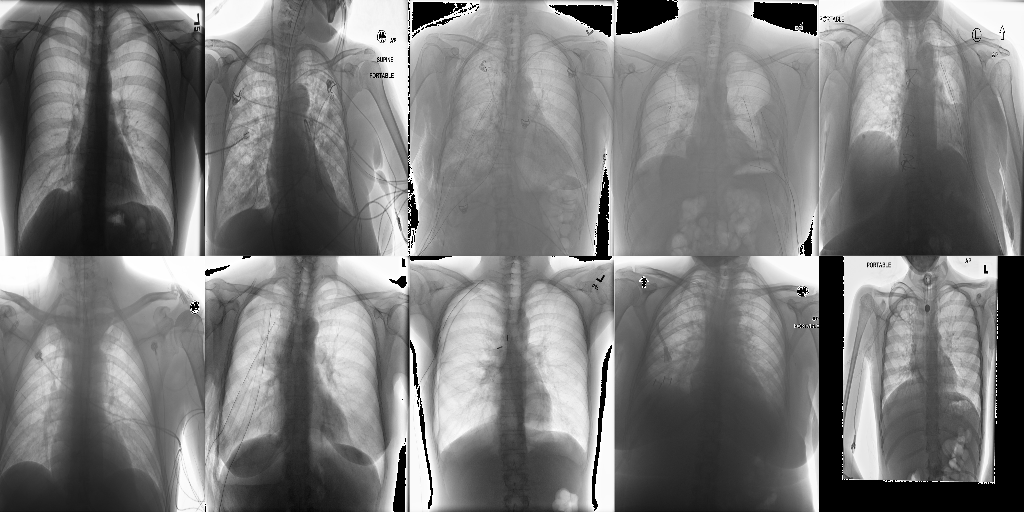

In [8]:
cvshow(cv2.resize( tiled, (1024,512), interpolation=cv2.INTER_LINEAR ))

These are some of the traditional ways to enhance an image. I used these techniques a lot but now deep learning has made them obsolete. You can find some visualization below.

## Rescaling Intensity
Using this function we can stretch/shrink its intensity levels.

## Contrast Limited Adaptive Histogram Equalization (CLAHE).

An algorithm for local contrast enhancement, that uses histograms computed
over different tile regions of the image. Local details can therefore be
enhanced even in regions that are darker or lighter than most of the image.

## Logarithmic Correction

This function transforms the input image pixelwise according to the
equation $O = gain*log(1 + I)$ after scaling each pixel to the range 0 to 1.

## Gamma Correction

Also known as Power Law Transform.
This function transforms the input image pixelwise according to the
equation $O = I*gamma$ after scaling each pixel to the range 0 to 1.






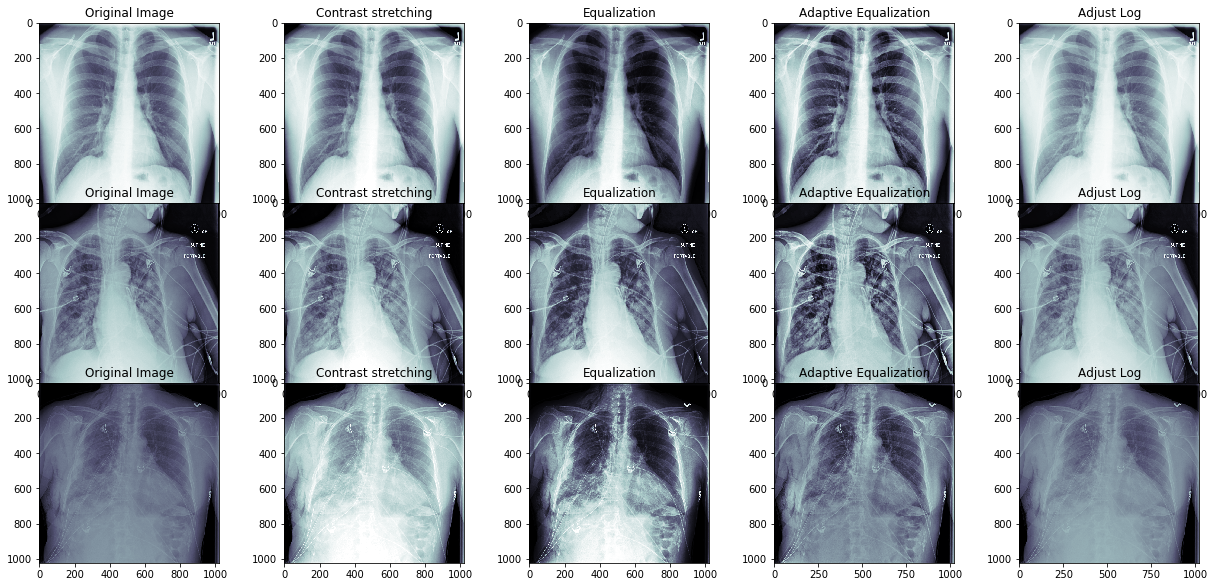

In [9]:
# simple ways to enhance the image

plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.7, hspace=0)  #adjust this to change vertical and horiz. spacings..
nImg = 3  #no. of images to process
for j in range(nImg):
    q = j+1
    img = np.array(pydicom.read_file(sample_files[j]).pixel_array)
    
#     # Contrast stretching
    p2, p97 = np.percentile(img, (2, 97))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p97))
    
    # Equalization
    img_eq = exposure.equalize_hist(img)

    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img)
    img_adjustlog = exposure.adjust_log(img)
    img_adjustgamma = exposure.adjust_gamma(img)
    
    plt.subplot(nImg,7,q*7-6)
    plt.imshow(img, cmap=plt.cm.bone)
    plt.title('Original Image')
    
    
    plt.subplot(nImg,7,q*7-5)    
    plt.imshow(img_rescale, cmap=plt.cm.bone)
    plt.title('Contrast stretching')
    
    
    plt.subplot(nImg,7,q*7-4)
    plt.imshow(img_eq, cmap=plt.cm.bone)
    plt.title('Equalization')
    
    
    plt.subplot(nImg,7,q*7-3)
    plt.imshow(img_adapteq, cmap=plt.cm.bone)
    plt.title('Adaptive Equalization')
    
    
    plt.subplot(nImg,7,q*7-2)
    plt.imshow(img_adjustgamma, cmap=plt.cm.bone)
    plt.title('Adjust Gamma')
    
    plt.subplot(nImg,7,q*7-2)
    plt.imshow(img_adjustlog, cmap=plt.cm.bone)
    plt.title('Adjust Log')



plt.show()

To download images you need to create an account on Google Cloud Products (GCP) and go through a series of messy process.. Providing the data on kaggle would have been so much easier!! 

In [10]:
train_glob = '../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-train/*/*/*.dcm'
test_glob = '../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/dicom-images-test/*/*/*.dcm'
train_fns = sorted(glob.glob(train_glob))
test_fns = sorted(glob.glob(test_glob))
df_mask = pd.read_csv('../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/train-rle.csv', index_col='ImageId')

In [11]:
len(df_mask),len(set(df_mask.index.values))

(11582, 10675)

In [12]:
df_mask_dist = df_mask.copy(deep=True)
df_mask_dist.reset_index(inplace=True)

df = pd.DataFrame(df_mask_dist.ImageId.value_counts()).reset_index()
df.columns = ['ImageId','counts']

df_mask_dist = pd.merge(df_mask_dist,df,on='ImageId')
df_mask_dist.head()

,ImageId,EncodedPixels,counts
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1,1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1,1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...,1
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...,4
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...,4


Text(0.5, 0, 'Number of Annotations')

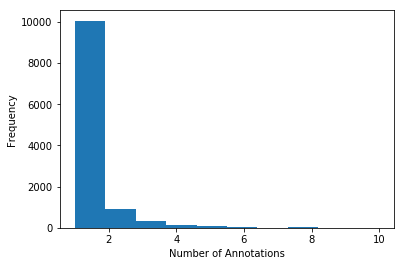

In [13]:
df_mask_dist.counts.plot.hist()
plt.xlabel('Number of Annotations')

In [14]:
def get_image_data(im_path,im_type,df_mask=df_mask):
    if im_type=='train':
        return pydicom.dcmread(im_path).pixel_array

In [15]:
train_fn_id = [val.split('/')[-1][:-4] for val in train_fns]
print(len(set(train_fn_id).intersection(set(df_mask_dist.ImageId))))

10675


In [16]:
masks_count_gt_one = set(df_mask_dist[df_mask_dist.counts>4].ImageId.values)
print('Number of masks with annotations greater than 5:',(df_mask_dist.counts>5).sum())
common_masks =  list(set(train_fn_id).intersection(masks_count_gt_one))
print(len(common_masks))

Number of masks with annotations greater than 5: 51
25


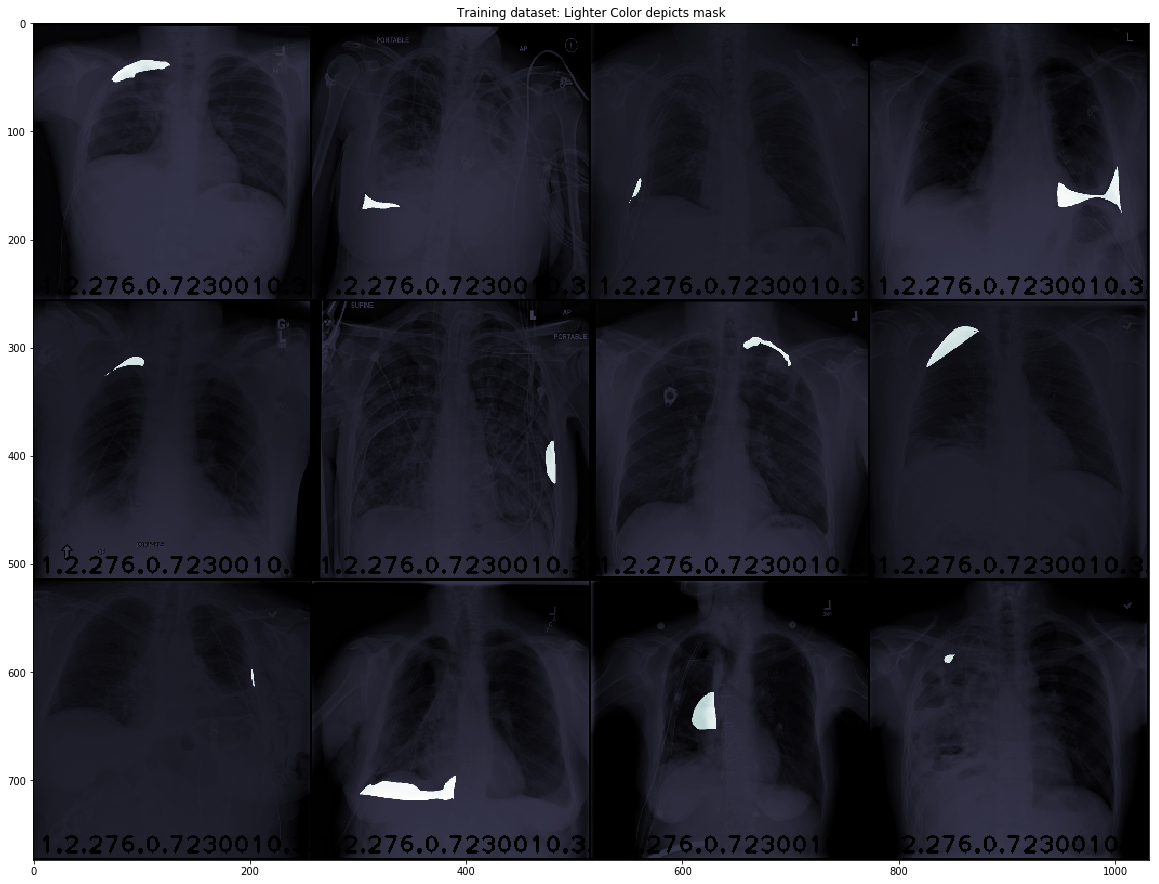

In [17]:
nImg = 12  #no. of images that you want to display
np.random.seed(42)
sel_train_fns = [train_fns[train_fn_id.index(c_m)] for c_m in common_masks]

_train_ids = list(sel_train_fns)
np.random.shuffle(_train_ids)
_train_ids = _train_ids[:nImg]
tile_size = (256, 256)
n = 4
alpha = 0.25

m = int(np.ceil(len(_train_ids) * 1.0 / n))
complete_image = np.zeros((m*(tile_size[0]+2), n*(tile_size[1]+2), 1), dtype=np.uint8)
complete_image_masked = np.zeros((m*(tile_size[0]+2), n*(tile_size[1]+2), 1), dtype=np.uint8)

counter = 0
for i in range(m):
    ys = i*(tile_size[1] + 2)
    ye = ys + tile_size[1]
    for j in range(n):
        xs = j*(tile_size[0] + 2)
        xe = xs + tile_size[0]
        if counter == len(_train_ids):
            break
        image_path = _train_ids[counter]; counter+=1
        img = get_image_data(image_path, 'train')
        
        num_annot = len(df_mask.loc[image_path.split('/')[-1][:-4]].values)
#         print('num_annot',num_annot)
        for i in range(num_annot):
            mask =  rle2mask(df_mask.loc[image_path.split('/')[-1][:-4]].iloc[i][0], 1024, 1024).T
            
        mask = mask.astype(np.uint8)
        
        img_masked =  cv2.addWeighted(img, alpha, mask, 1 - alpha,0)
#         img_masked = cv2.bitwise_and(img, img, mask=mask)

        img = cv2.resize(img, dsize=tile_size)
        img_masked = cv2.resize(img_masked, dsize=tile_size)
        
        img_masked = cv2.putText(img_masked, image_path.split('/')[-1][:-4], (5,img.shape[0] - 5), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), thickness=2)
        complete_image_masked[ys:ye, xs:xe, :] = img_masked[:,:,None]
        
    if counter == len(_train_ids):
        break    
    
m = complete_image.shape[0] / (tile_size[0] + 2)
k = 8
n = int(np.ceil(m / k))
for i in range(n):
    plt.figure(figsize=(20, 20))
    ys = i*(tile_size[0] + 2)*k
    ye = min((i+1)*(tile_size[0] + 2)*k, complete_image.shape[0])
    plt.imshow(complete_image_masked[ys:ye,:,0],cmap='bone')
    plt.title("Training dataset: Lighter Color depicts mask")